In [20]:
import numpy as np
import pandas as pd
from pandas import read_csv
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
import torch.optim as optim
from models import MLP
import matplotlib.pyplot as plt

In [21]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Data Preprocessing

In [22]:
df_train = pd.read_csv('intern_homework_train_dataset.csv')
df_test = pd.read_csv('intern_homework_public_test_dataset.csv')

has_update = df_train['title'].str.contains('#更新|\(更新\)|\(更\)|#更|2更|更2|更\)|\(更').astype(int)
df_train['update'] = has_update

has_update = df_test['title'].str.contains('#更新|\(更新\)|\(更\)|#更|2更|更2|更\)|\(更').astype(int)
df_test['update'] = has_update

df_train['created_at'] = pd.to_datetime(df_train['created_at'], format='%Y-%m-%d %H:%M:%S %Z')
df_train['hour'] = df_train['created_at'].apply(lambda x: x.hour)
df_train['weekday'] = df_train['created_at'].apply(lambda x: x.weekday)

df_test['created_at'] = pd.to_datetime(df_test['created_at'], format='%Y-%m-%d %H:%M:%S %Z')
df_test['hour'] = df_test['created_at'].apply(lambda x: x.hour)
df_test['weekday'] = df_test['created_at'].apply(lambda x: x.weekday)

df_train_label = df_train["like_count_24h"]
df_train_input = df_train.drop(['author_id', 'like_count_24h', 'forum_id', 'created_at', 'title'], axis=1)

df_test_label = df_test["like_count_24h"]
df_test_input = df_test.drop(['author_id', 'like_count_24h', 'forum_id', 'created_at', 'title'], axis=1)

train_input = df_train_input.values
train_label = df_train_label.values
test_input = df_test_input.values
test_label = df_test_label.values

## DataLoader

In [23]:
TrainBatchSize = 5000
TestBatchSize = 2000

train_input = torch.Tensor(train_input)
train_label = torch.Tensor(train_label)

test_input = torch.Tensor(test_input)
test_label = torch.Tensor(test_label)

train = TensorDataset(train_input, train_label)
train_dataload = DataLoader(train, batch_size=TrainBatchSize, shuffle=True)

test = TensorDataset(test_input, test_label)
test_dataload = DataLoader(test, batch_size=TestBatchSize, shuffle=False)

## MLP Training 

In [33]:
MLP_model = MLP()
MLP_model.to(device)
optimizer = optim.Adam(MLP_model.parameters(), lr=0.01, weight_decay=0.001)
min_loss=100.0
train_plot = []
test_plot = []

for epoch in range(1000):
   
    MLP_model.train()
    train_loss = 0.0
    correct = 0
    
    for i, (data, label) in enumerate(train_dataload):
        
        data = data.to(device)
        label = label.to(device)
        
        # clear gradient
        optimizer.zero_grad()

        # Forward propagation
        output = MLP_model(data)
    
        label = torch.reshape(label, (TrainBatchSize, 1))
        
        # Calculate MAPE
        loss = torch.mean(torch.abs((label - output) / label) * 100)/(50000/TrainBatchSize)
        
        # Calculate gradients
        loss.backward()

        # Update parameters
        optimizer.step()
        
        train_loss += loss.item()
    
    train_plot.append(train_loss)
    if((epoch+1)%10==0):
        print("---------------------------------------")
        print("{}th epoch training Loss: ".format(epoch+1))
        print(train_loss)
    
    MLP_model.eval()
    with torch.no_grad():
    
        test_loss = 0.0
        correct = 0
        
        for i, (data, label) in enumerate(test_dataload):
            
            data = data.to(device)
            label = label.to(device)
            
            output = MLP_model(data)
            output[output < 5] = 5
            label = torch.reshape(label, (TestBatchSize, 1))
            
            loss = torch.mean(torch.abs((label - output) / label) * 100)/(10000/TestBatchSize)
        
            test_loss += loss.item()
    
    test_plot.append(test_loss)
    if((epoch+1)%10==0):
        print("{}th epoch testing Loss: ".format(epoch+1))
        print(test_loss)
    
    if(test_loss<min_loss):
        min_loss=test_loss
    
    if(test_loss<=30.1):
        torch.save(MLP_model, 'best_model.pt')

print("Minimum Loss: ")
print(min_loss)

---------------------------------------
10th epoch training Loss: 
31.59526252746582
10th epoch testing Loss: 
32.68810701370239
---------------------------------------
20th epoch training Loss: 
30.7864990234375
20th epoch testing Loss: 
31.777812957763672
---------------------------------------
30th epoch training Loss: 
30.34091877937317
30th epoch testing Loss: 
31.90329122543335
---------------------------------------
40th epoch training Loss: 
30.16845464706421
40th epoch testing Loss: 
31.63116979598999
---------------------------------------
50th epoch training Loss: 
29.4933660030365
50th epoch testing Loss: 
31.435558795928955
---------------------------------------
60th epoch training Loss: 
29.39879584312439
60th epoch testing Loss: 
30.97070550918579
---------------------------------------
70th epoch training Loss: 
29.3064227104187
70th epoch testing Loss: 
31.089273929595947
---------------------------------------
80th epoch training Loss: 
29.17149543762207
80th epoch t

## Plotting

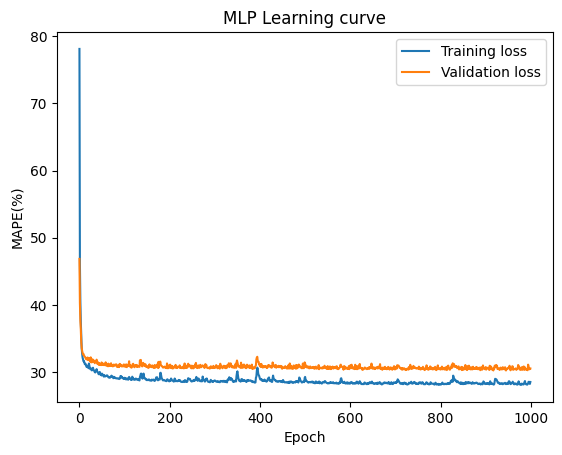

In [34]:
x = np.arange(1000)
plt.plot(x, train_plot, label='Training loss')
plt.plot(x, test_plot, label='Validation loss')

plt.xlabel('Epoch')
plt.ylabel('MAPE(%)')
plt.title('MLP Learning curve')
plt.legend()

plt.show()